# Movie Recommendation System — MovieLens 1M (Light)
**Notebook file:** `movie_recommender_ml1m.ipynb`  
**Purpose:** simple, clear pipeline: load ML-1M, content-based (TF-IDF), collaborative (Surprise SVD), and a small hybrid demo. Designed to run on a typical laptop.


In [21]:
# Setup & imports (paths assume notebook in /notebooks, data in project root /data/ml-1m)
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler

# Surprise (collaborative)
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy

# Paths
NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent
DATA_DIR = ROOT / "data" / "ml-1m"

print("Notebook dir:", NOTEBOOK_DIR)
print("Project root:", ROOT)
print("Expected dataset directory:", DATA_DIR)


Notebook dir: c:\Users\Admin\Desktop\6th\ML\Project\movie-recommendation-system\notebooks
Project root: c:\Users\Admin\Desktop\6th\ML\Project\movie-recommendation-system
Expected dataset directory: c:\Users\Admin\Desktop\6th\ML\Project\movie-recommendation-system\data\ml-1m


**Before running:** download MovieLens 1M from:
https://files.grouplens.org/datasets/movielens/ml-1m.zip  
Extract the `ml-1m` folder into `movie-recommendation-system/data/ml-1m/`.


In [46]:
# ML-1M files use "::" as separator -> use engine='python'
movies = pd.read_csv(DATA_DIR / "movies.csv", sep="::", engine="python",
                     names=['movieId', 'title', 'genres'], encoding='latin-1')
ratings = pd.read_csv(DATA_DIR / "ratings.csv", sep="::", engine="python",
                      names=['userId', 'movieId', 'rating', 'timestamp'])
users = pd.read_csv(DATA_DIR / "users.csv", sep="::", engine="python",
                    names=['userId', 'gender', 'age', 'occupation', 'zip'])

print("movies:", movies.shape)
print("ratings:", ratings.shape)
print("users:", users.shape)

# Quick peek
movies.head()


movies: (3883, 3)
ratings: (1000209, 4)
users: (6040, 5)


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [52]:
# Convert dtypes for small memory improvements
ratings['userId'] = ratings['userId'].astype(np.int32)
ratings['movieId'] = ratings['movieId'].astype(np.int32)
ratings['rating'] = ratings['rating'].astype(np.float32)

# Split genres pipe -> space for TF-IDF
movies['genre_text'] = movies['genres'].str.replace('|', ' ', regex=False)
movies['text'] = movies['title'].fillna('') + ' ' + movies['genre_text'].fillna('')

# merge ratings with titles for EDA if needed
df = ratings.merge(movies[['movieId','title']], on='movieId', how='left')
df.head()


# ===== CELL 3: Preprocess Movie Text for TF-IDF =====

def create_movie_text(movies):
    # Fill missing text fields
    movies['genres'] = movies['genres'].fillna('')
    movies['title'] = movies['title'].fillna('')

    # Combine meaningful fields
    movies['text_for_tfidf'] = (
        movies['title'] + " " +
        movies['genres'] + " "

    )

    # Remove movies with empty text
    movies = movies[movies['text_for_tfidf'].str.strip() != ""]
    return movies

movies = create_movie_text(movies)
print("Movies after preprocessing:", movies.shape)



Movies after preprocessing: (3883, 6)


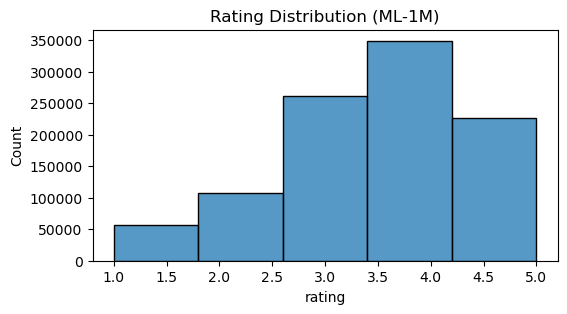

Top 10 movies by rating count:
 title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: rating, dtype: int64


In [53]:
# Rating distribution
plt.figure(figsize=(6,3))
sns.histplot(ratings['rating'], bins=5)
plt.title("Rating Distribution (ML-1M)")
plt.show()

# Top movies by number of ratings
top_counts = df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
print("Top 10 movies by rating count:\n", top_counts)



## Content-based recommender
We compute TF-IDF on `title + genres` and use cosine similarity (via linear_kernel) to recommend movies similar to a given movie.


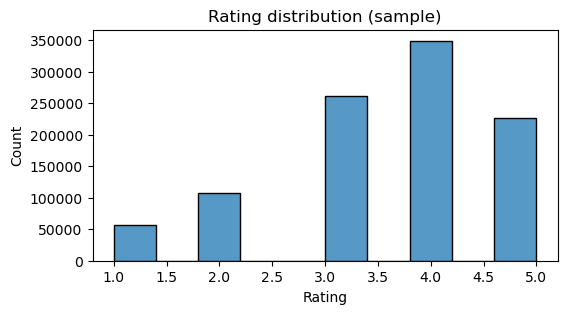

Top 10 movies by rating count in sample:
 title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
Name: rating, dtype: int64


In [27]:
# Cell: EDA
plt.figure(figsize=(6,3))
sns.histplot(df['rating'], bins=10)
plt.title("Rating distribution (sample)")
plt.xlabel("Rating")
plt.show()

counts = df.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
print("Top 10 movies by rating count in sample:\n", counts)


## Content-based recommender (title + genres)
We build a TF-IDF vectorizer on a combined `title + genres` text field and compute cosine similarities between movies.


In [55]:
# ===== CELL 4: Build Optimized TF-IDF Matrix =====

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tfidf = TfidfVectorizer(stop_words='english', max_features=20000)  # LIMIT features
tfidf_matrix = tfidf.fit_transform(movies['text_for_tfidf'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("Memory safe — cosine similarity not computed fully.")



TF-IDF matrix shape: (3883, 4369)
Memory safe — cosine similarity not computed fully.


In [56]:
# ===== CELL 5: Content-Based Recommender =====

def recommend_similar_movies(movie_id, k=10):
    # get index of the movie inside DataFrame
    try:
        idx = movies.index[movies['movieId'] == movie_id][0]
    except:
        return "Movie ID not found."

    # compute similarity only with one row (safe)
    sim_scores = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()

    # get top k similar movies (skip itself)
    similar_indices = sim_scores.argsort()[::-1][1:k+1]

    return movies.iloc[similar_indices][['movieId', 'title']]


In [58]:
# ===== CELL 6: Test Recommendation =====

test_id = 318  # try any movieId from dataset
recommendations = recommend_similar_movies(test_id, k=10)
recommendations


,movieId,title
382,386,S.F.W. (1994)
286,289,Only You (1994)
249,252,I.Q. (1994)
336,340,"War, The (1994)"
278,281,Nobody's Fool (1994)
457,461,Go Fish (1994)
279,282,Nell (1994)
404,408,8 Seconds (1994)
468,472,I'll Do Anything (1994)
378,382,Wolf (1994)


## Collaborative recommender (SVD via Surprise)
We train SVD on the ML-1M ratings and evaluate with a simple train/test split. Then we'll use the trained SVD to recommend top-N movies to a user by predicting ratings for unseen movies.


In [34]:
# Prepare Surprise dataset from pandas DataFrame
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

# train-test split and SVD training
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

algo = SVD(n_factors=50, n_epochs=20, random_state=42)
algo.fit(trainset)

# Evaluate on testset (RMSE)
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions, verbose=True)


RMSE: 0.8706


In [35]:
# Build a helper: for a given user, predict ratings for all movies not yet rated and return top N
all_movie_ids = movies['movieId'].unique().tolist()
ratings_by_user = ratings.groupby('userId')['movieId'].apply(set).to_dict()

def recommend_svd_for_user(user_id, top_n=10):
    if user_id not in ratings_by_user:
        print("Cold-start: user has no ratings in dataset. Recommend popular movies instead.")
        popular = df.groupby('title')['rating'].count().sort_values(ascending=False).head(top_n)
        return movies[movies['title'].isin(popular.index)][['movieId','title','genres']]
    rated = ratings_by_user[user_id]
    candidates = [mid for mid in all_movie_ids if mid not in rated]
    preds = []
    for mid in candidates:
        pred = algo.predict(user_id, mid)
        preds.append((mid, pred.est))
    preds_sorted = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    recs = pd.DataFrame(preds_sorted, columns=['movieId','pred_rating'])
    recs = recs.merge(movies[['movieId','title','genres']], on='movieId', how='left')
    return recs

# Demo for an example user (userId 1 exists)
recommend_svd_for_user(1, top_n=10)


,movieId,pred_rating,title,genres
0,318,4.996461,"Shawshank Redemption, The (1994)",Drama
1,593,4.912123,"Silence of the Lambs, The (1991)",Drama|Thriller
2,2905,4.902345,Sanjuro (1962),Action|Adventure
3,2019,4.883954,Seven Samurai (The Magnificent Seven) (Shichin...,Action|Drama
4,1212,4.865285,"Third Man, The (1949)",Mystery|Thriller
5,1250,4.847158,"Bridge on the River Kwai, The (1957)",Drama|War
6,904,4.826586,Rear Window (1954),Mystery|Thriller
7,2925,4.820050,"Conformist, The (Il Conformista) (1970)",Drama
8,296,4.818425,Pulp Fiction (1994),Crime|Drama
9,912,4.810864,Casablanca (1942),Drama|Romance|War


## Hybrid recommender (simple fusion)
For a given user and seed movie, combine:
- Content similarity to the seed movie (content scores)
- SVD predicted rating for the user (collab score)
We normalize both and compute weighted sum to rank candidates.


In [44]:
scaler = MinMaxScaler()

def recommend_hybrid(user_id, seed_movie_id, top_n=10, alpha=0.6):
    # content scores relative to seed movie
    if seed_movie_id not in movie_id_to_idx:
        raise ValueError("Seed movie not found.")
    seed_idx = movie_id_to_idx[seed_movie_id]
    content_scores = content_sim[seed_idx]   # length = #movies
    
    # collaborative: predicted rating by user for all movies
    candidates = movies['movieId'].values
    coll_scores = np.array([algo.predict(user_id, mid).est if mid not in ratings_by_user.get(user_id, set()) else -1 
                            for mid in candidates])
    
    # normalize (minmax)
    c_norm = scaler.fit_transform(content_scores.reshape(-1,1)).ravel()
    coll_norm = scaler.fit_transform(coll_scores.reshape(-1,1)).ravel()
    
    # combine (alpha weight to content)
    hybrid = alpha * c_norm + (1-alpha) * coll_norm
    # mask out movies user already rated (so we don't recommend them)
    rated_set = ratings_by_user.get(user_id, set())
    mask = np.isin(candidates, list(rated_set), invert=True)
    # apply mask and get top indices
    valid_idxs = np.where(mask)[0]
    valid_scores = hybrid[valid_idxs]
    top_local = valid_idxs[np.argsort(valid_scores)[::-1][:top_n]]
    recs = movies.iloc[top_local][['movieId','title','genres']]
    return recs.reset_index(drop=True)

# Demo: hybrid recommendations for user 1 using seed movie 1 (Toy Story)
recommend_hybrid(user_id=1, seed_movie_id=1, top_n=10, alpha=0.6)


,movieId,title,genres
0,13,Balto (1995),Animation|Children's
1,2274,Lilian's Story (1995),Drama
2,1033,"Fox and the Hound, The (1981)",Animation|Children's
3,96,In the Bleak Midwinter (1995),Comedy
4,3400,We're Back! A Dinosaur's Story (1993),Animation|Children's
5,241,Fluke (1995),Children's|Drama
6,2961,"Story of Us, The (1999)",Comedy|Drama
7,364,"Lion King, The (1994)",Animation|Children's|Musical
8,2108,L.A. Story (1991),Comedy|Romance
9,171,Jeffrey (1995),Comedy


## Usage notes & saving artifacts
- Use `recommend_content_by_movie(movie_id)`, `recommend_svd_for_user(user_id)`, and `recommend_hybrid(user_id, seed_movie_id)` for recommendations.
- To save models/artifacts (optional), pickle the trained `algo` (SVD) and `tfidf` objects.


In [59]:
# Optional: save SVD algo and TF-IDF for reuse
import pickle
MODEL_DIR = ROOT / "models"
MODEL_DIR.mkdir(exist_ok=True)
with open(MODEL_DIR / "svd_algo.pkl", "wb") as f:
    pickle.dump(algo, f)
with open(MODEL_DIR / "tfidf.pkl", "wb") as f:
    pickle.dump(tfidf, f)
print("Saved models to", MODEL_DIR)


Saved models to c:\Users\Admin\Desktop\6th\ML\Project\movie-recommendation-system\models
